In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from config import *
from keras import backend as Ker
Ker.tensorflow_backend._get_available_gpus()
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Convolution1D, Convolution2D, Convolution3D, Flatten, MaxPooling2D, Dropout, LSTM, Bidirectional, Input, Add, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization

/home/jeff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jeff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jeff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jeff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

In [2]:
def get_data():
    validation_ratio = 0.2
    test_ratio = 0.3
    bp_iter_num = 5
    X_train = np.zeros((1,n+1,N,bp_iter_num,2))
    Y_train = np.zeros((1,K))
    X_test = np.zeros((1,n+1,N,bp_iter_num,2))
    Y_test = np.zeros((1,K))
    X_val = np.zeros((1,n+1,N,bp_iter_num,2))
    Y_val= np.zeros((1,K))
    Y2K = np.cumsum(-1*FZlookup)-1
    for i in range(len(ebn0)):
        with open("./Data/X_SNR_"+str(N)+"_"+str(i)+"_1_0.p", "rb") as file:
            x = pickle.load(file)
        with open("./Data/Y_SNR_"+str(N)+"_"+str(i)+"_1_0.p", "rb") as file:
            y = pickle.load(file)
        y_tmp = np.zeros((len(x),K))
        X_train = np.concatenate((X_train, x[:int(len(x)*(1-test_ratio)*(1-validation_ratio)),:,:,:,:]), axis=0)
        X_test = np.concatenate((X_test, x[int(len(x)*(1-test_ratio)):,:,:,:,:]), axis=0)
        X_val = np.concatenate((X_val, x[int(len(x)*(1-test_ratio)*(1-validation_ratio)):int(len(x)*(1-test_ratio)),:,:,:,:]), axis=0)
        for j in range(len(y)):
            y_tmp[j,:] = np.sum(to_categorical(Y2K[y[j]],K),0)
        Y_train = np.concatenate((Y_train, y_tmp[:int(len(x)*(1-test_ratio)*(1-validation_ratio)),:]), axis=0)
        Y_test = np.concatenate((Y_test, y_tmp[int(len(x)*(1-test_ratio)):,:]), axis=0)
        Y_val = np.concatenate((Y_val, y_tmp[int(len(x)*(1-test_ratio)*(1-validation_ratio)):int(len(x)*(1-test_ratio)),:]), axis=0)
    X_train = X_train[1:,:,:,:,:]
    X_test = X_test[1:,:,:,:,:]
    X_val = X_val[1:,:,:,:,:]
    Y_train = Y_train[1:,:]
    Y_test = Y_test[1:,:]
    Y_val = Y_val[1:,:]
    print("Training data:   ",X_train.shape)
    print("Validation data: ",X_val.shape)
    print("Testing data:    ",X_test.shape)
    return X_train, X_test, X_val, Y_train, Y_test, Y_val

In [3]:
def acc(target, output):
    max_idx = tf.argmax(output,1)
    idx = tf.cast(tf.range(0, tf.shape(output)[0], 1),tf.int64)
    idx = tf.stack([idx,max_idx],1)
    value = tf.gather_nd(target,idx)
    return tf.reduce_mean(value)

In [4]:
def true_acc(y_test, y_pred, num_of_tries):
    max_idx = np.argsort(y_pred,1)[:,::-1][:,:num_of_tries]
    value = np.take_along_axis(y_test,max_idx,1)
    acc = []
    for i in range(num_of_tries):
        acc.append(np.round(np.mean(np.sum(value[:,:i+1],1)>0),5))
    return acc

In [5]:
def train(X_train, X_test, X_val, Y_train, Y_test, Y_val):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(X_train.shape[1:])))
    model.add(Convolution2D(32,(3,3),padding='same',input_shape=(X_train.shape[1:]), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(16,(3,3),padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(8,(3,3),padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(Y_train.shape[1], activation='sigmoid'))
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=[acc])
    model.summary()
#     if(os.path.exists('Model/Uni_'+str(N)+'.h5')):
#         model.load_weights('Model/Uni_'+str(N)+'.h5')
    earlystopping = EarlyStopping(monitor='val_acc', patience = 10, verbose=0, mode='max')
    checkpoint = ModelCheckpoint(filepath='Model/Uni_'+str(N)+'.h5', verbose=1, save_best_only=True, save_weights_only=True, monitor='val_acc', mode='max')
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=60, batch_size=500, verbose=1, shuffle=True, callbacks=[earlystopping,checkpoint])
    model.load_weights('Model/Uni_'+str(N)+'.h5')
    return model

In [6]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = get_data()

X_train_pic = (np.concatenate((np.abs(X_train[:,:,:,:,0]),np.sign(X_train[:,:,:,:,0]),np.sign(X_train[:,:,:,:,1])), axis=3)).reshape((-1,n+1,N,15))
X_test_pic = (np.concatenate((np.abs(X_test[:,:,:,:,0]),np.sign(X_test[:,:,:,:,0]),np.sign(X_test[:,:,:,:,1])), axis=3)).reshape((-1,n+1,N,15))
X_val_pic = (np.concatenate((np.abs(X_val[:,:,:,:,0]),np.sign(X_val[:,:,:,:,0]),np.sign(X_val[:,:,:,:,1])), axis=3)).reshape((-1,n+1,N,15))

model = train(X_train_pic, X_test_pic, X_val_pic, Y_train, Y_test, Y_val)

Training data:    (50400, 6, 32, 5, 2)
Validation data:  (12600, 6, 32, 5, 2)
Testing data:     (27000, 6, 32, 5, 2)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 6, 32, 15)         60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 32, 32)         4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 32, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 32, 16)         4624      
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 32, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 32, 8)          1160      
___

In [7]:
weight_path = '{0}_{1}_{2}.ckpt'.format(N,ebn0[0],ebn0[-1])
f_results = open('Results/NN/Uni_'+weight_path[:-4]+'txt', 'w+')

y_pred = model.predict(X_train_pic,batch_size=2000)
print('Training:', true_acc(Y_train,y_pred,CS.shape[0]*2))
y_pred = model.predict(X_test_pic,batch_size=2000)
print('Testing: ', true_acc(Y_test,y_pred,CS.shape[0]*2))
f_results.write('Testing: ' + str(true_acc(Y_test,y_pred,CS.shape[0]*2))+'\n')
L = int(len(Y_test)/len(ebn0))
for i in range(len(ebn0)):
    print('SNR: '+str(i)+', '+str(true_acc(Y_test[i*L:(i+1)*L],y_pred[i*L:(i+1)*L],CS.shape[0]*2)))
    f_results.write('SNR: '+str(i)+', '+str(true_acc(Y_test[i*L:(i+1)*L],y_pred[i*L:(i+1)*L],CS.shape[0]*2))+'\n')

Training: [0.50313, 0.66609, 0.75748, 0.81766, 0.85883, 0.89024, 0.91796, 0.93796, 0.95375, 0.96675, 0.97657, 0.9846, 0.99046, 0.99524]
Testing:  [0.45267, 0.60952, 0.70256, 0.76456, 0.81181, 0.84859, 0.87967, 0.90667, 0.92641, 0.94552, 0.96126, 0.97333, 0.98233, 0.99059]
SNR: 0, [0.425, 0.57711, 0.67478, 0.74022, 0.78822, 0.83167, 0.86122, 0.89178, 0.91311, 0.93556, 0.95367, 0.96822, 0.97822, 0.98922]
SNR: 1, [0.45611, 0.60811, 0.69778, 0.76078, 0.80967, 0.84378, 0.87911, 0.906, 0.92611, 0.94578, 0.962, 0.97356, 0.98333, 0.99044]
SNR: 2, [0.47689, 0.64333, 0.73511, 0.79267, 0.83756, 0.87033, 0.89867, 0.92222, 0.94, 0.95522, 0.96811, 0.97822, 0.98544, 0.99211]


In [8]:
pred = np.zeros(Y_test.shape)

# order of critical set
for j in range(CS.shape[0]):
    pred[:,int(CS[j])] = 1-(j/K)

SNR: 0, [2448. 2056. 1405. 1712. 1255. 1093.  742.  772.  984.  927.  989. 1086.
 1151. 1134. 1197. 1107.], [0.10933, 0.37122, 0.51778, 0.61411, 0.68367, 0.74867, 0.782]
SNR: 1, [2533. 2109. 1444. 1715. 1227. 1186.  759.  741. 1046.  966. 1047. 1074.
 1280. 1195. 1280. 1091.], [0.11622, 0.38767, 0.53367, 0.62533, 0.69222, 0.76122, 0.79167]
SNR: 2, [2516. 2318. 1624. 1792. 1163. 1227.  771.  799. 1103. 1081. 1182. 1138.
 1343. 1296. 1327. 1095.], [0.12256, 0.38933, 0.55189, 0.63233, 0.70711, 0.77389, 0.80356]


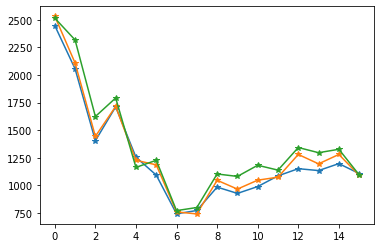

In [9]:
# calculate CS_BF accuracy
L = int(len(Y_test)/len(ebn0))
f_results.write('\nCS Testing: \n')
for i in range(len(ebn0)):
    cnt = np.sum(Y_test[i*L:(i+1)*L,:],0)
    print('SNR: '+str(i)+', '+str(cnt)+', '+str(true_acc(Y_test[i*L:(i+1)*L,:],pred[i*L:(i+1)*L,:],CS.shape[0])))
    f_results.write('SNR: '+str(i)+', '+str(true_acc(Y_test[i*L:(i+1)*L],pred[i*L:(i+1)*L,:],CS.shape[0]))+'\n')    
    plt.plot(np.sum(Y_test[i*L:(i+1)*L],0),marker='*')
f_results.flush()